# SHL AI Hiring Task: Automated Essay Scoring using NLP
------

Dataset derived from: https://drive.google.com/drive/folders/1zIoIniVDhLz-oFXVAmu1SMgWg9OmGZIl?usp=sharing

Questionnaire: https://docs.google.com/document/d/1UXtQ6fCWnGz9BZ6y2vYfVtwv22gUz1w3q7afopgy6GY/edit

*Coding initiated on 17th September 2021 at 3:53 pm by RSK*

## **STEP ZERO**: Pre-requisite prep
-------
1. Import all necessary libraries and set constant variables
2. Upload and Import train and test datasets


In [16]:
!pip install pyspellchecker
# import all necessary libraries

# For dataframes
import pandas as pd 

# For numerical arrays
import numpy as np 

# For stemming/Lemmatisation/POS tagging
import spacy

# For getting stopwords
from spacy.lang.en.stop_words import STOP_WORDS

# For K-Fold cross validation
from sklearn.model_selection import KFold

# For visualizations
import matplotlib.pyplot as plt

# For regular expressions
import re

# For handling string
import string

# For all torch-supported actions
import torch

# For spell-check
from spellchecker import SpellChecker

# For performing mathematical operations
import math

# For dictionary related activites
from collections import defaultdict

# For counting actions (EDA)
from collections import  Counter

# For count vectorisation (EDA)
from sklearn.feature_extraction.text import CountVectorizer

# For one-hot encoding
from tensorflow.keras.utils import to_categorical

# For DL model
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant

# For generating random integers
from random import randint

import os 

# For TF-IDF vectorisation
from sklearn.feature_extraction.text import TfidfVectorizer

# For padding
from tensorflow.keras.preprocessing.sequence import pad_sequences

# For tokenization
from tensorflow.keras.preprocessing.text import Tokenizer

# For plotting
import seaborn as sns

print("Necessary libraries imported")

# Constant variables 

# spaCy language lemmatiser model
sp=spacy.load('en_core_web_sm')
spell = SpellChecker()

# CONSTANTS FOR TRAINING
MAX_SEQUENCE_LENGTH = 500
MAX_NUM_WORDS = 5000 
EMBEDDING_DIM = 100 
VALIDATION_SPLIT = 0.2

print("Constant variables ready")

Necessary libraries imported
Constant variables ready


In [5]:
%%capture
'''
from google.colab import drive
drive.mount('/content/gdrive')
'''
try:
    
    from google.colab import files
    
    !wget -P DATAPATH http://nlp.stanford.edu/data/glove.6B.zip
    !unzip DATAPATH/glove.6B.zip -d DATAPATH/glove.6B
    
    !wget -P DATAPATH http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    !tar -xvf DATAPATH/aclImdb_v1.tar.gz -C DATAPATH
    
    BASE_DIR = 'DATAPATH'
    
except ModuleNotFoundError:
    
    if not os.path.exists('Data/glove.6B'):
        os.mkdir('Data/glove.6B')
        
        url='http://nlp.stanford.edu/data/glove.6B.zip'  
        wget.download(url,'Data')  
  
        temp='Data/glove.6B.zip' 
        file = ZipFile(temp)  
        file.extractall('Data/glove.6B') 
        file.close()

GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')
TRAIN_DATA_DIR = os.path.join(BASE_DIR, 'aclImdb/train')
TEST_DATA_DIR = os.path.join(BASE_DIR, 'aclImdb/test')

In [6]:
# import train and test datasets

df=pd.read_csv('/content/sample_data/train.csv')
df=df.drop(['Unnamed: 0'], axis=1)

df.head()

,Unnamed: 0,promptId,uniqueId,essay,evaluator_rating,avg_char_per_word,total_words,corpus,class
0,0,1,1_323,"At present age, our education system is not go...",3.0,4.59,306,present age education system good thing requir...,6.0
1,1,1,1_238,I am agree the tightly defined curriculum of o...,4.0,5.78,299,agree tightly define curriculum education syst...,8.0
2,2,1,1_212,I strongly agree with the statement that tight...,2.0,4.78,158,strongly agree statement tight schedule educat...,4.0
3,3,1,1_117,Our education system is nice quitely but i dis...,2.0,4.91,312,education system nice quitely disagree change ...,4.0
4,4,1,1_229,i am totally agree with the statement that tig...,3.0,4.36,339,totally agree statement tightly define curricu...,6.0


## **STEP ONE**: Exploratory Data Analysis
-------
1. View the basic characteristics of the training dataset
2. Inspect key properties of essays like number of words, number of characters per word, most used word and least used word, etc.


In [22]:
#basic observable characteristics 
print("shape of dataset: ",df.shape)
print("sample essay: ",df.essay.iloc[randint(0,len(df))])
print("Total null values: \n",df.isnull().sum())

shape of dataset:  (1240, 9)
sample essay:  THE TIGHTLY DEFINED CURRICULAM OF OUR EDUCATION SYSTEM LEAVES NO ROOM FOR IMAGINATION AND CREATIVITYKnowledge may leads you from A to BBut Imagination can leads you anywhere.                        - Albert EinsteinImagination is one of the most discussed and important word accross the world becoz it's highlighted the the creation idea of any indivusals. For every creation new idea gives birth of an invention. The creative ideas can be devolped day by day so for that it should be in since the school level of a childern that they can get enough chances top develop their own. But in India there is a rat race in every field and Education system is the main share holder of that race. Here thestudents are bound to learned how to memorized some words and data and by putting them in a paper how to get good grades to take a job outside of this country. But we have the device named calculator to store that things then why a student 'll waste their vit

In [23]:
# For getting word-len characteristics of essays

def get_avg_len(text):
  words=text.split()
  word_len=0
  for word in words:
    word_len+=len(word)
  
  ret= round(word_len/len(words),2)
  return ret

def total_words(text):
  words=text.split()
  return len(words)

df['avg_char_per_word']=df.essay.apply(lambda x: get_avg_len(x))
df['total_words']=df.essay.apply(lambda x: total_words(x))

df.head()

,Unnamed: 0,promptId,uniqueId,essay,evaluator_rating,avg_char_per_word,total_words,corpus,class
0,0,1,1_323,"At present age, our education system is not go...",3.0,4.59,306,present age education system good thing requir...,6.0
1,1,1,1_238,I am agree the tightly defined curriculum of o...,4.0,5.78,299,agree tightly define curriculum education syst...,8.0
2,2,1,1_212,I strongly agree with the statement that tight...,2.0,4.78,158,strongly agree statement tight schedule educat...,4.0
3,3,1,1_117,Our education system is nice quitely but i dis...,2.0,4.91,312,education system nice quitely disagree change ...,4.0
4,4,1,1_229,i am totally agree with the statement that tig...,3.0,4.36,339,totally agree statement tightly define curricu...,6.0


**AIM** : *To study the distribution of evaluated scores against all prompts*

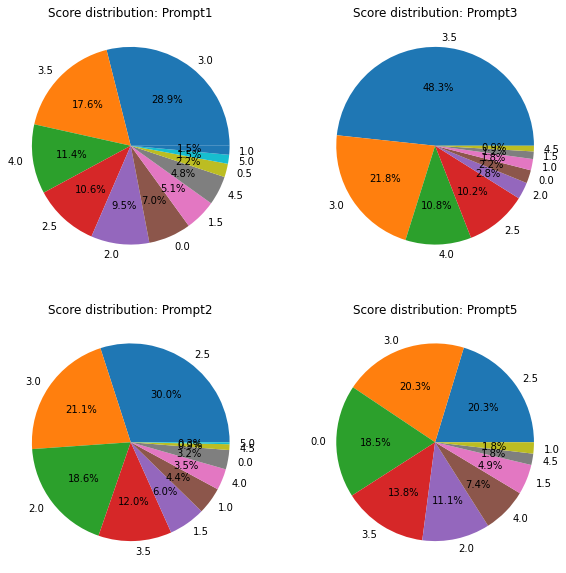

In [25]:
fig = plt.figure(figsize=(10,10))
prompt_id_list=[1,2,3,5]
for prompt in range(0,4):
  curdf=df[df['promptId']==prompt_id_list[prompt]]
  labels = []
  sizes = []
  for x, y in curdf.evaluator_rating.value_counts().items():
    labels.append(x)
    sizes.append(y)
  ax1 = plt.subplot2grid((2,2),((prompt)%2,math.floor((prompt)/2)))
  plt.pie(sizes,labels=labels,autopct='%1.1f%%')
  plt.title('Score distribution: Prompt'+str(prompt_id_list[prompt]))
plt.show()


**The following conclusions can be made from these series of pie charts:**

1. There is a big difference in the evaluation methods of each prompt (18.5% of total attendees of prompt 5 got zero marks, whereas the chance of getting zero in prompt 3 is only 3.2%)

2. The distribution of marks are not even, instead mostly scattered around 2.5-3.5

**AIM**: *To gather insights about evaluator's score versus average word length for each prompt*

Graph for evaluator rating vs avg word length


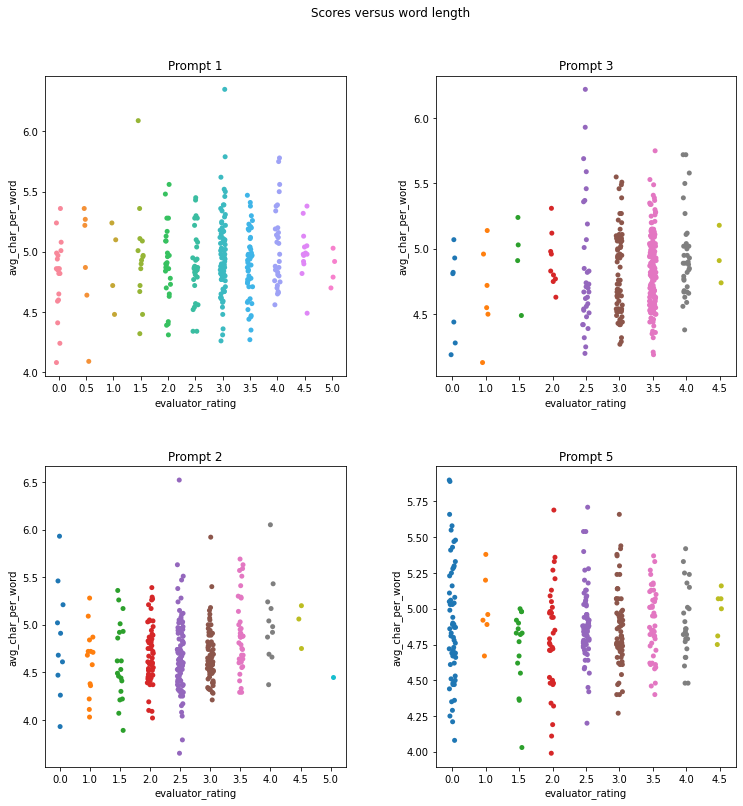

In [26]:
print("Graph for evaluator rating vs avg word length")

fig, axes = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('Scores versus word length')

prompt_id_list=[1,2,3,5]
for prompt in range(0,4):
  curdf=df[df['promptId']==prompt_id_list[prompt]]  
  sns.stripplot(ax=axes[prompt%2,math.floor(prompt/2)],
    data=curdf,
    x="evaluator_rating", y="avg_char_per_word")
  axes[prompt%2,math.floor(prompt/2)].set_title("Prompt "+str(prompt_id_list[prompt]))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)
fig.show()



**The following conclusions can be made from these series of seaborn charts:**

1. There is variation of word length versus score with respect to the type of prompt. 

2. To the naked eye, no significant trend/pattern can be found which maps word-length to score

**AIM**: *To gather insights about evaluator's score versus total words used in an essay for each prompt*

Graph for evaluator rating vs total words in essay


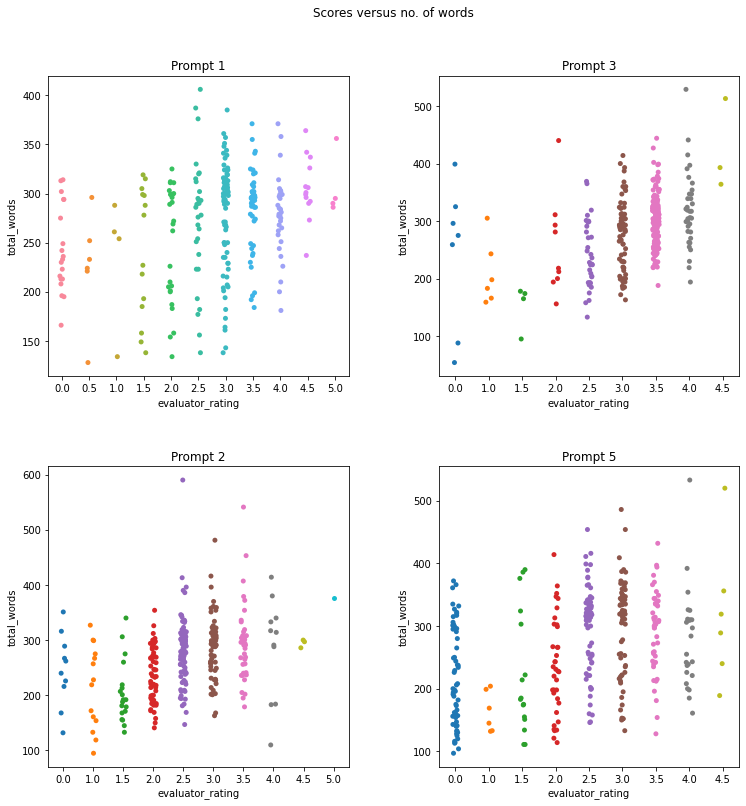

In [27]:
print("Graph for evaluator rating vs total words in essay")

fig, axes = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('Scores versus no. of words')

prompt_id_list=[1,2,3,5]
for prompt in range(0,4):
  curdf=df[df['promptId']==prompt_id_list[prompt]]  
  sns.stripplot(ax=axes[prompt%2,math.floor(prompt/2)],
    data=curdf,
    x="evaluator_rating", y="total_words")
  axes[prompt%2,math.floor(prompt/2)].set_title("Prompt "+str(prompt_id_list[prompt]))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)
fig.show()



**The following conclusions can be made from these series of seaborn charts:**

1. The marks awarded is highly scattered across total words in all prompts. There are cases where 200+ words are used still less marks are awarded. 

2. Prompt 3 shows lesser scattering, and is the most "obedient" in terms of total-words-based-variance, while Prompt 1 performing the worst

**AIM**: *To find the presence/frequency of stopwords*

Stop Words in all essay prompts


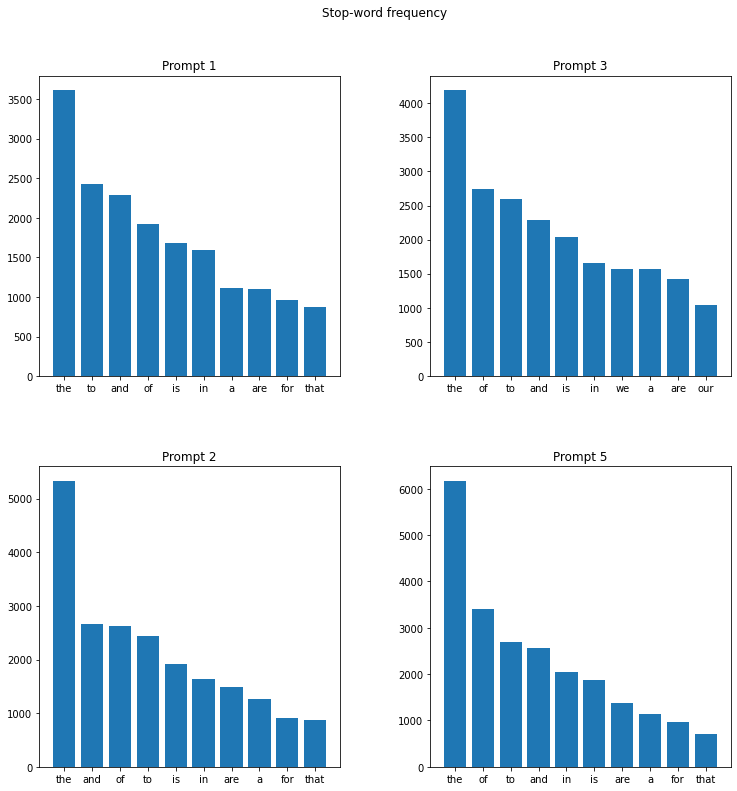

In [28]:
print("Stop Words in all essay prompts")

fig, axes = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('Stop-word frequency')

prompt_id_list=[1,2,3,5]
for prompt in range(0,4):
  dct=defaultdict(int) 
  curdf=df[df['promptId']==prompt_id_list[prompt]]  
  for essay in curdf.essay:
    for word in essay.split():
      if word in STOP_WORDS:
          dct[word]+=1
  top=sorted(dct.items(), key=lambda x:x[1],reverse=True)[:10] 
  x,y=zip(*top)
  axes[prompt%2,math.floor(prompt/2)].bar(x,y)
  axes[prompt%2,math.floor(prompt/2)].set_title("Prompt "+str(prompt_id_list[prompt]))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)
fig.show()

        


From the above bar graphs, it is clear that a lot of stop-words are present, which raises the necessity to do stopword cleaning

**AIM**: *To find the presence/frequency of Punctuations*

Punctuations in all essay prompts


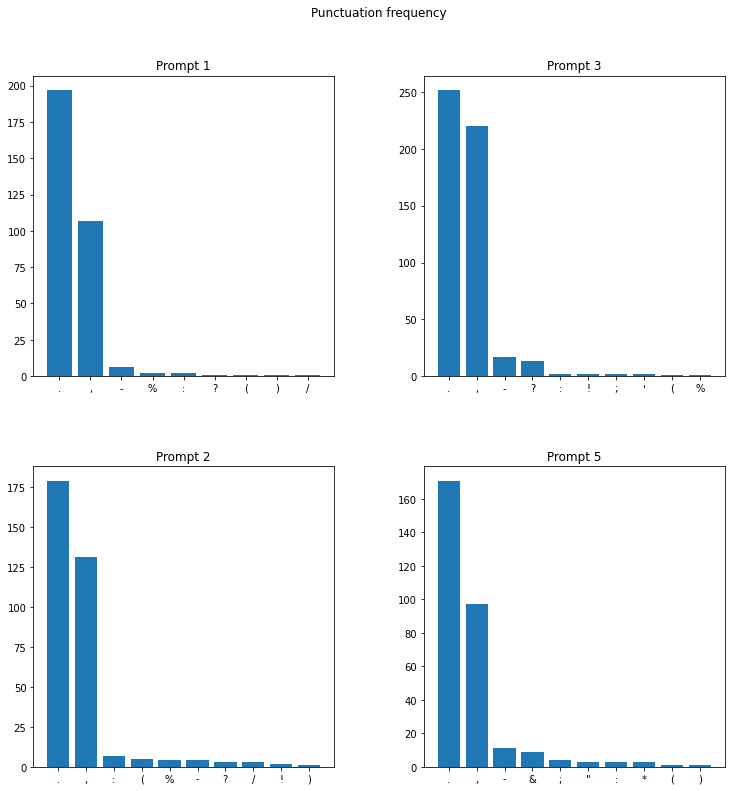

In [29]:
print("Punctuations in all essay prompts")

fig, axes = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('Punctuation frequency')
special = string.punctuation

prompt_id_list=[1,2,3,5]
for prompt in range(0,4):
  dct=defaultdict(int) 
  curdf=df[df['promptId']==prompt_id_list[prompt]]  
  for essay in curdf.essay:
    for word in essay.split():
      if word in special:
          dct[word]+=1
  top=sorted(dct.items(), key=lambda x:x[1],reverse=True)[:10] 
  x,y=zip(*top)
  axes[prompt%2,math.floor(prompt/2)].bar(x,y)
  axes[prompt%2,math.floor(prompt/2)].set_title("Prompt "+str(prompt_id_list[prompt]))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)
fig.show()


Hence, it is clear that punctuations also need to be removed.

**AIM**: *To find the words that occur commonly under each prompt*

Most commonly occcuring words in all essay prompts


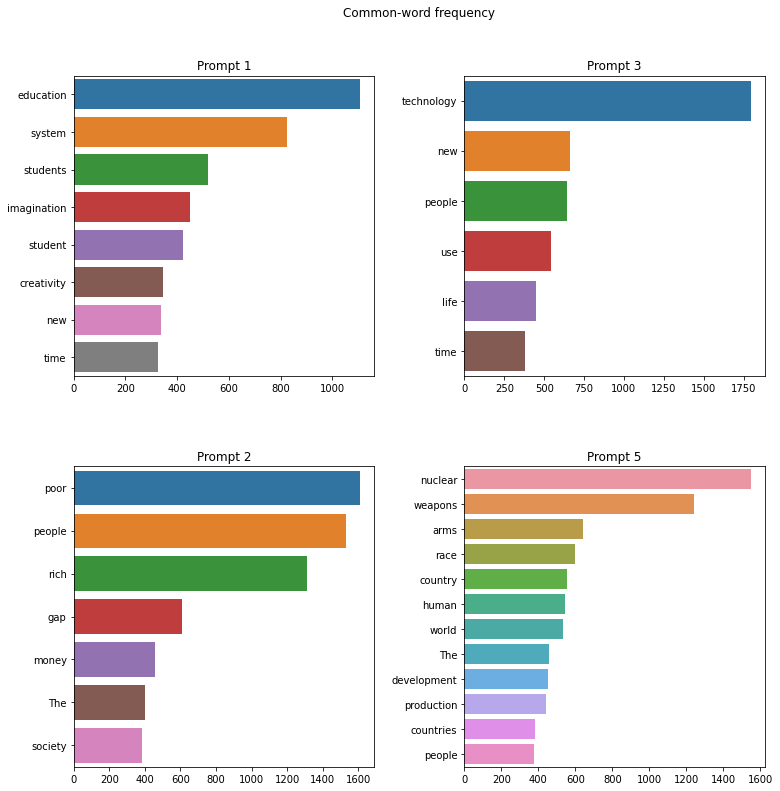

In [30]:
print("Most commonly occcuring words in all essay prompts")

fig, axes = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('Common-word frequency')

prompt_id_list=[1,2,3,5]
for prompt in range(0,4):
  dct=defaultdict(int) 
  curdf=df[df['promptId']==prompt_id_list[prompt]]  
  counter=Counter((" ".join(curdf.essay)).split())
  most=counter.most_common()
  x=[]
  y=[]
  for word,count in most[:40]:
      if (word not in STOP_WORDS) :
          x.append(word)
          y.append(count)
  sns.barplot(ax=axes[prompt%2,math.floor(prompt/2)],x=y,y=x)
  axes[prompt%2,math.floor(prompt/2)].set_title("Prompt "+str(prompt_id_list[prompt]))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)
fig.show()


The following conclusions can be drawn from this graph:
1. Most frequently occuring words are highly related to the topic of the prompt ("education" in prompt 1 correlates to the education-based description of prompt 1, and so on)
2. There is a respectable amount different non-stop-words that occur frequently under each prompt, which makes it fairly straight-forward to incorporate the richness into the autocoring model.

**AIM**: *To analyse most-occuring bigrams in essays of all prompts* 

Bigram analysis


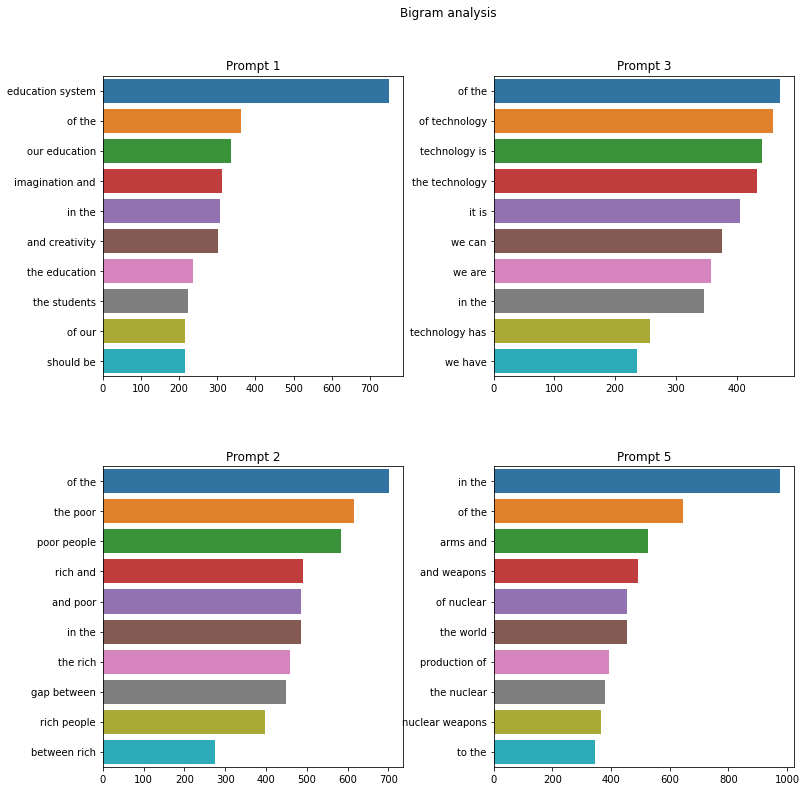

In [31]:
def get_top_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

print("Bigram analysis")

fig, axes = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('Bigram analysis')

prompt_id_list=[1,2,3,5]
for prompt in range(0,4):
  dct=defaultdict(int) 
  top_bigrams=get_top_bigrams(df[df['promptId']==prompt_id_list[prompt]].essay)[:10]
  x,y=map(list,zip(*top_bigrams))
  sns.barplot(ax=axes[prompt%2,math.floor(prompt/2)],x=y,y=x)
  axes[prompt%2,math.floor(prompt/2)].set_title("Prompt "+str(prompt_id_list[prompt]))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)
fig.show()



The following inferences can be drawn WRT the above graphs:
1. Bi-gram popularity is directly related to topic of prompt
2. Stop-words need to be removed to make bi-grams more content-related

## **STEP TWO**: Text Cleaning
------
1. Convert to lowercase
2. Treat punctuations
3. Remove numbers
4. Remove emojis, URLs and HTMLs (if any)
4. Spell-correct
5. Stop word removal
5. Stem and Lemmatise

In [20]:
## Text cleaning


punctuation_counter=0
digit_counter=0

# Translates punctuations to space, and then removes multiple spaces
def remove_punct(text):
    global punctuation_counter
    for i in string.punctuation:
      punctuation_counter+=text.count(i)
    
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    text=text.translate(translator)
    return re.sub(' +', ' ', text)


# Replaces digits with whitespaces, and removes multiple spaces
def remove_digits(text):
    global digit_counter
    for c in ["0","1","2","3","4","5","6","7","8","9"]:
        digit_counter+=text.count(c)

    text = re.sub(r'[0-9]', ' ', text)
    return re.sub(' +', ' ', text)



# Removes all html tags that are of form <>
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)


# Removes all hyperlinks (if any)
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)


# Removes all emojis (if any)
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

#Applies lemmatization
def lemmatize(text):
     return " ".join(map(lambda x : x.lemma_, sp(text)))

#Corrects mispelled words
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

def stopwords(text):
  return " ".join(map(lambda x : x.lemma_,
                      [token for token in sp(text) if not token.is_stop]))


def cleaner(text):
  text=text.lower()
  text=remove_html(text)
  text=remove_URL(text)
  text=remove_emoji(text)
  text=remove_punct(text) 
  text=remove_digits(text)
  text=correct_spellings(text) #This function consumes a lot of run-time
  text=stopwords(text)
  text=lemmatize(text)
  return text

example_string="HELLO56,MY WORDD :) HTTPS://WWW.GITHUB.COM, SUP?"

print("Cleaned version of '",example_string,"' is: ",cleaner(example_string))

Cleaned version of ' HELLO56,MY WORDD :) HTTPS://WWW.GITHUB.COM, SUP? ' is:  hello world sup


In [ ]:
df['corpus']=df.essay.apply(lambda x: cleaner(str(x)))
#df=pd.read_csv('cleaned.csv')
print('Cleaning done, \nPunctuations removed: ',punctuation_counter,'\nDigits removed: ',digit_counter)
df.head()

Cleaning done, 
Punctuations removed:  30403 
Digits removed:  2157


,promptId,uniqueId,essay,evaluator_rating,avg_char_per_word,total_words,corpus
0,1,1_323,"At present age, our education system is not go...",3.0,4.59,306,present age education system good thing requir...
1,1,1_238,I am agree the tightly defined curriculum of o...,4.0,5.78,299,agree tightly define curriculum education syst...
2,1,1_212,I strongly agree with the statement that tight...,2.0,4.78,158,strongly agree statement tight schedule educat...
3,1,1_117,Our education system is nice quitely but i dis...,2.0,4.91,312,education system nice quitely disagree change ...
4,1,1_229,i am totally agree with the statement that tig...,3.0,4.36,339,totally agree statement tightly define curricu...


Hence, upon making keen observations from the EDA, the approach to the NLP pipeline is as follows:
1. Treat this as a multi-class classification problem (score from 0 to 5 is discrete and hence class-based)
2. Develop separate models for separate prompts
3. Clean (correct spellings, remove digits and punctuations)
4. Feature engineer (Tokenise and convert to sequence of numbers)
5. Make cross validation sets
6. LSTM-net model

## **STEP THREE**: Feature Engineering

1. Tokenise
2. Convert to sequence of digits
3. Pad


In [8]:
dataset=[]
idx=0
prompt_to_index=dict()

score_dict={}
class_dict={}
for i in np.arange(0.0,5.5,0.5):
  class_dict[i]=i*2;
  score_dict[i*2]=i;

df['class']=df.evaluator_rating.apply(lambda x:class_dict[x]);
for i in df.promptId.unique():
  dataset.append(df[df.promptId==i])
  prompt_to_index[i]=idx
  idx+=1


In [10]:
# Create tokenizers (objects that convert text to vectors) and sequence vectors
# For each prompt separately

tokenizer = []
sequences=[]
labels=[]
word_indexes=[]
for prompt in range(0,4):
  tokenizer_curr=Tokenizer() 
  tokenizer_curr.fit_on_texts(dataset[prompt].corpus) 
  sequence_curr=tokenizer_curr.texts_to_sequences(dataset[prompt].corpus)
  word_index = tokenizer_curr.word_index   
  word_indexes.append(word_index)
  print('Found ',len(word_index),' unique tokens for prompt ' ,prompt, ' With ',len(sequence_curr),' essays, and the maximum string length being ',max([len(i) for i in sequence_curr]))
  sequence_curr = pad_sequences(sequence_curr, maxlen=MAX_SEQUENCE_LENGTH)
  
  tokenizer.append(tokenizer_curr)
  sequences.append(sequence_curr)
  labels.append(np.asarray(dataset[prompt].evaluator_rating))
  #labels.append(to_categorical(np.asarray(dataset[prompt]['class'])))
  

Found  3590  unique tokens for prompt  0  With  273  essays, and the maximum string length being  171
Found  3969  unique tokens for prompt  1  With  317  essays, and the maximum string length being  247
Found  4508  unique tokens for prompt  2  With  325  essays, and the maximum string length being  230
Found  4302  unique tokens for prompt  3  With  325  essays, and the maximum string length being  260


In [ ]:
'''
# Split the training data into a training set and a validation set
# Note that each list stores 4 sets:- train/val sets of each prompt
x_train=[] 
y_train=[]
x_val=[]
y_val=[]

for prompt in range(0,4):
  indices = np.arange(sequences[prompt].shape[0])
  np.random.shuffle(indices)
  train_cur = sequences[prompt][indices]
  train_labels = labels[prompt][indices]
  val_samples = math.ceil(VALIDATION_SPLIT * sequences[prompt].shape[0])
  x_train.append(sequences[prompt][:-(val_samples)])
  y_train.append(labels[prompt][:-(val_samples)])
  x_val.append(sequences[prompt][-(val_samples):])
  y_val.append(labels[prompt][-(val_samples):])
#This is the data we will use for CNN and RNN training
print('Splitting the train data into train and valid is done')

for prompt in range(0,4):
  print('x-train and x-val shape for prompt ',prompt,': ',x_train[prompt].shape,' and ',x_val[prompt].shape)
  
  print('y-train and y-val shape for prompt ',prompt,': ',y_train[prompt].shape,' and ',y_val[prompt].shape)

'''

Splitting the train data into train and valid is done
x-train and x-val shape for prompt  0 :  (218, 500)  and  (55, 500)
y-train and y-val shape for prompt  0 :  (218,)  and  (55,)
x-train and x-val shape for prompt  1 :  (253, 500)  and  (64, 500)
y-train and y-val shape for prompt  1 :  (253,)  and  (64,)
x-train and x-val shape for prompt  2 :  (260, 500)  and  (65, 500)
y-train and y-val shape for prompt  2 :  (260,)  and  (65,)
x-train and x-val shape for prompt  3 :  (260, 500)  and  (65, 500)
y-train and y-val shape for prompt  3 :  (260,)  and  (65,)


## **STEP FOUR**: Model building

We develop a model that has
- an embedding layer
- LSTM with dropout
- LSTM with dropout
- Dense
- single node output

The model will be:
- evaluated by RMS
- hypertuned by adam

Preparing embedding matrix.
Preparing of embedding matrix is done
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5000, 100)         359100    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 480,509
Trainable params: 121,409
Non-trainable params: 359,100
_________________________________________________________________
None

 Prompt  0  Fold  0
Epoch 1/20
6/6 [==============================] - 11s 1s/step - loss: 5.0834 - mae: 1.9847 - val_loss: 1.6007 - val_mae: 0.9487
Epoch 2/20
6/6 [====

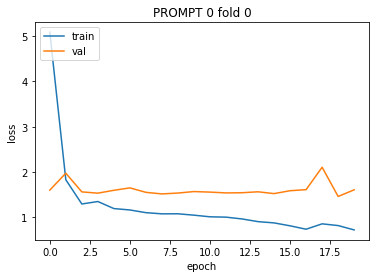


 Prompt  0  Fold  1
Epoch 1/20
6/6 [==============================] - 8s 1s/step - loss: 1.1198 - mae: 0.7909 - val_loss: 0.6000 - val_mae: 0.6248
Epoch 2/20
6/6 [==============================] - 8s 1s/step - loss: 1.0849 - mae: 0.8236 - val_loss: 0.5776 - val_mae: 0.5731
Epoch 3/20
6/6 [==============================] - 8s 1s/step - loss: 1.0370 - mae: 0.7653 - val_loss: 0.6495 - val_mae: 0.6509
Epoch 4/20
6/6 [==============================] - 8s 1s/step - loss: 0.9482 - mae: 0.7669 - val_loss: 0.5364 - val_mae: 0.5742
Epoch 5/20
6/6 [==============================] - 10s 2s/step - loss: 0.7854 - mae: 0.6690 - val_loss: 0.5115 - val_mae: 0.5613
Epoch 6/20
6/6 [==============================] - 8s 1s/step - loss: 0.7271 - mae: 0.6533 - val_loss: 0.5599 - val_mae: 0.6065
Epoch 7/20
6/6 [==============================] - 8s 1s/step - loss: 0.6217 - mae: 0.5880 - val_loss: 0.5347 - val_mae: 0.5931
Epoch 8/20
6/6 [==============================] - 8s 1s/step - loss: 0.5366 - mae: 0.5727

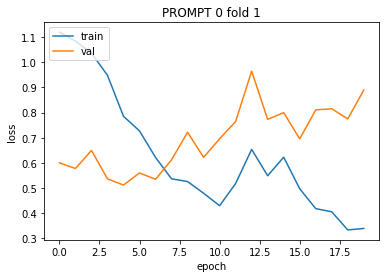


 Prompt  0  Fold  2
Epoch 1/20
6/6 [==============================] - 8s 1s/step - loss: 0.5948 - mae: 0.5907 - val_loss: 0.3085 - val_mae: 0.4506
Epoch 2/20
6/6 [==============================] - 8s 1s/step - loss: 0.5816 - mae: 0.6054 - val_loss: 0.2088 - val_mae: 0.3553
Epoch 3/20
6/6 [==============================] - 8s 1s/step - loss: 0.4893 - mae: 0.5364 - val_loss: 0.2545 - val_mae: 0.3902
Epoch 4/20
6/6 [==============================] - 8s 1s/step - loss: 0.3577 - mae: 0.4747 - val_loss: 0.2627 - val_mae: 0.3935
Epoch 5/20
6/6 [==============================] - 8s 1s/step - loss: 0.3183 - mae: 0.4623 - val_loss: 0.2991 - val_mae: 0.4207
Epoch 6/20
6/6 [==============================] - 8s 1s/step - loss: 0.2815 - mae: 0.4276 - val_loss: 0.3698 - val_mae: 0.4726
Epoch 7/20
6/6 [==============================] - 8s 1s/step - loss: 0.2495 - mae: 0.4097 - val_loss: 0.2933 - val_mae: 0.4093
Epoch 8/20
6/6 [==============================] - 8s 1s/step - loss: 0.2499 - mae: 0.3964 

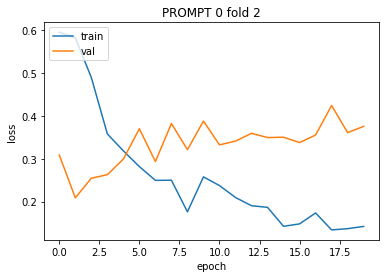

Preparing embedding matrix.
Preparing of embedding matrix is done
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 5000, 100)         397000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 518,409
Trainable params: 121,409
Non-trainable params: 397,000
_________________________________________________________________
None

 Prompt  1  Fold  0
Epoch 1/20
7/7 [==============================] - 13s 1s/step - loss: 3.3659 - mae: 1.5771 - val_loss: 1.1452 - val_mae: 0.8703
Epoch 2/20
7/7 [====

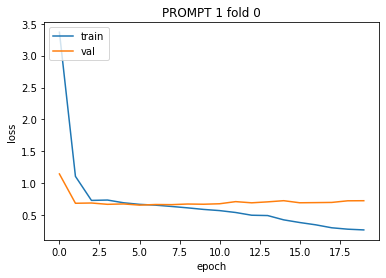


 Prompt  1  Fold  1
Epoch 1/20
7/7 [==============================] - 10s 1s/step - loss: 0.5000 - mae: 0.5266 - val_loss: 0.4196 - val_mae: 0.5011
Epoch 2/20
7/7 [==============================] - 10s 1s/step - loss: 0.5018 - mae: 0.5176 - val_loss: 0.3013 - val_mae: 0.4081
Epoch 3/20
7/7 [==============================] - 12s 2s/step - loss: 0.4471 - mae: 0.4852 - val_loss: 0.2667 - val_mae: 0.3853
Epoch 4/20
7/7 [==============================] - 10s 1s/step - loss: 0.4511 - mae: 0.5219 - val_loss: 0.3523 - val_mae: 0.4708
Epoch 5/20
7/7 [==============================] - 10s 1s/step - loss: 0.3937 - mae: 0.4648 - val_loss: 0.2919 - val_mae: 0.4117
Epoch 6/20
7/7 [==============================] - 10s 1s/step - loss: 0.3046 - mae: 0.4094 - val_loss: 0.2966 - val_mae: 0.4131
Epoch 7/20
7/7 [==============================] - 10s 1s/step - loss: 0.2816 - mae: 0.4000 - val_loss: 0.4320 - val_mae: 0.5214
Epoch 8/20
7/7 [==============================] - 10s 1s/step - loss: 0.2644 - mae:

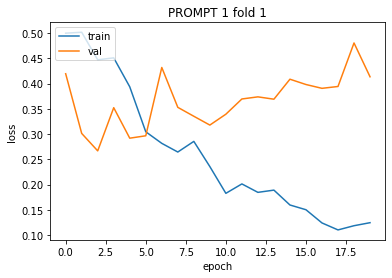


 Prompt  1  Fold  2
Epoch 1/20
7/7 [==============================] - 10s 1s/step - loss: 0.2423 - mae: 0.3662 - val_loss: 0.0472 - val_mae: 0.1743
Epoch 2/20
7/7 [==============================] - 10s 1s/step - loss: 0.2295 - mae: 0.3716 - val_loss: 0.1225 - val_mae: 0.2785
Epoch 3/20
7/7 [==============================] - 10s 1s/step - loss: 0.2681 - mae: 0.3981 - val_loss: 0.0990 - val_mae: 0.2559
Epoch 4/20
7/7 [==============================] - 10s 1s/step - loss: 0.2523 - mae: 0.3928 - val_loss: 0.1254 - val_mae: 0.2745
Epoch 5/20
7/7 [==============================] - 10s 1s/step - loss: 0.1815 - mae: 0.3334 - val_loss: 0.1016 - val_mae: 0.2414
Epoch 6/20
7/7 [==============================] - 10s 1s/step - loss: 0.1352 - mae: 0.2797 - val_loss: 0.0813 - val_mae: 0.2256
Epoch 7/20
7/7 [==============================] - 10s 1s/step - loss: 0.1630 - mae: 0.3191 - val_loss: 0.1368 - val_mae: 0.2849
Epoch 8/20
7/7 [==============================] - 10s 1s/step - loss: 0.1580 - mae:

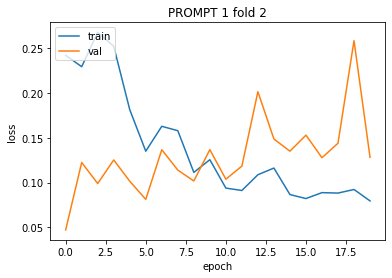

Preparing embedding matrix.
Preparing of embedding matrix is done
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 5000, 100)         450900    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_6 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 572,309
Trainable params: 121,409
Non-trainable params: 450,900
_________________________________________________________________
None

 Prompt  2  Fold  0
Epoch 1/20
7/7 [==============================] - 13s 1s/step - loss: 3.3297 - mae: 1.5347 - val_loss: 1.7170 - val_mae: 0.9843
Epoch 2/20
7/7 [====

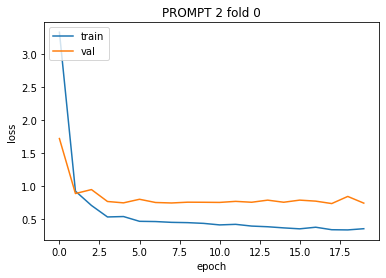


 Prompt  2  Fold  1
Epoch 1/20
7/7 [==============================] - 10s 1s/step - loss: 0.5342 - mae: 0.5058 - val_loss: 0.2828 - val_mae: 0.3711
Epoch 2/20
7/7 [==============================] - 12s 2s/step - loss: 0.4839 - mae: 0.4751 - val_loss: 0.3051 - val_mae: 0.4243
Epoch 3/20
7/7 [==============================] - 10s 1s/step - loss: 0.4508 - mae: 0.4879 - val_loss: 0.3527 - val_mae: 0.4135
Epoch 4/20
7/7 [==============================] - 10s 1s/step - loss: 0.4452 - mae: 0.4735 - val_loss: 0.3540 - val_mae: 0.4042
Epoch 5/20
7/7 [==============================] - 10s 1s/step - loss: 0.4988 - mae: 0.5143 - val_loss: 0.3751 - val_mae: 0.4108
Epoch 6/20
7/7 [==============================] - 10s 1s/step - loss: 0.4853 - mae: 0.4577 - val_loss: 0.3563 - val_mae: 0.4330
Epoch 7/20
7/7 [==============================] - 10s 1s/step - loss: 0.4002 - mae: 0.4622 - val_loss: 0.3980 - val_mae: 0.4344
Epoch 8/20
7/7 [==============================] - 10s 1s/step - loss: 0.3570 - mae:

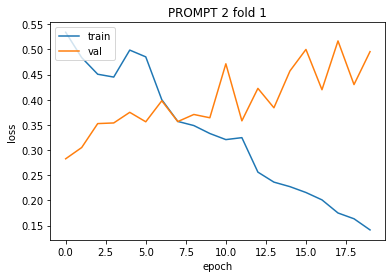


 Prompt  2  Fold  2
Epoch 1/20
7/7 [==============================] - 10s 1s/step - loss: 0.3550 - mae: 0.4327 - val_loss: 0.1266 - val_mae: 0.2683
Epoch 2/20
7/7 [==============================] - 10s 1s/step - loss: 0.3229 - mae: 0.4143 - val_loss: 0.2857 - val_mae: 0.3742
Epoch 3/20
7/7 [==============================] - 10s 1s/step - loss: 0.2720 - mae: 0.3900 - val_loss: 0.1952 - val_mae: 0.3296
Epoch 4/20
7/7 [==============================] - 10s 1s/step - loss: 0.2815 - mae: 0.4040 - val_loss: 0.1752 - val_mae: 0.3138
Epoch 5/20
7/7 [==============================] - 10s 1s/step - loss: 0.2192 - mae: 0.3578 - val_loss: 0.1691 - val_mae: 0.3306
Epoch 6/20
7/7 [==============================] - 10s 1s/step - loss: 0.2324 - mae: 0.3659 - val_loss: 0.1768 - val_mae: 0.3174
Epoch 7/20
7/7 [==============================] - 10s 1s/step - loss: 0.1749 - mae: 0.3284 - val_loss: 0.1693 - val_mae: 0.3143
Epoch 8/20
7/7 [==============================] - 10s 1s/step - loss: 0.1443 - mae:

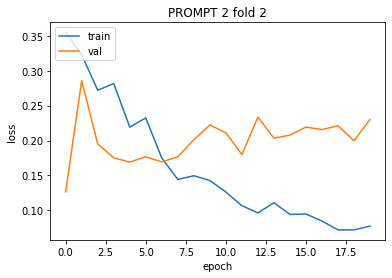

Preparing embedding matrix.
Preparing of embedding matrix is done
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 5000, 100)         430300    
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_8 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 551,709
Trainable params: 121,409
Non-trainable params: 430,300
_________________________________________________________________
None

 Prompt  3  Fold  0
Epoch 1/20
7/7 [==============================] - 13s 1s/step - loss: 3.5815 - mae: 1.5697 - val_loss: 2.7365 - val_mae: 1.2068
Epoch 2/20
7/7 [====

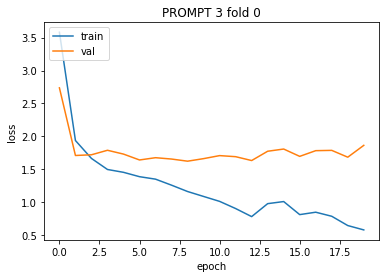


 Prompt  3  Fold  1
Epoch 1/20
7/7 [==============================] - 10s 1s/step - loss: 1.0838 - mae: 0.7662 - val_loss: 0.4926 - val_mae: 0.5582
Epoch 2/20
7/7 [==============================] - 10s 1s/step - loss: 1.0522 - mae: 0.7573 - val_loss: 0.7359 - val_mae: 0.6459
Epoch 3/20
7/7 [==============================] - 10s 1s/step - loss: 0.9351 - mae: 0.7141 - val_loss: 0.8705 - val_mae: 0.6653
Epoch 4/20
7/7 [==============================] - 10s 1s/step - loss: 0.8636 - mae: 0.6811 - val_loss: 1.0065 - val_mae: 0.7410
Epoch 5/20
7/7 [==============================] - 10s 1s/step - loss: 0.9373 - mae: 0.7429 - val_loss: 0.6194 - val_mae: 0.6277
Epoch 6/20
7/7 [==============================] - 10s 1s/step - loss: 0.7620 - mae: 0.6579 - val_loss: 0.7109 - val_mae: 0.6559
Epoch 7/20
7/7 [==============================] - 10s 1s/step - loss: 0.6621 - mae: 0.6221 - val_loss: 0.8012 - val_mae: 0.6894
Epoch 8/20
7/7 [==============================] - 10s 1s/step - loss: 0.6673 - mae:

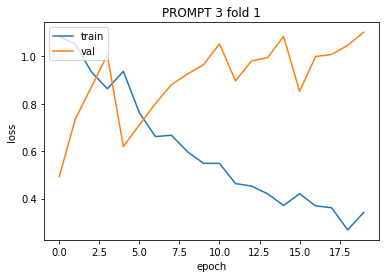


 Prompt  3  Fold  2
Epoch 1/20
7/7 [==============================] - 10s 1s/step - loss: 0.7185 - mae: 0.6286 - val_loss: 0.1279 - val_mae: 0.2576
Epoch 2/20
7/7 [==============================] - 10s 1s/step - loss: 0.6041 - mae: 0.5787 - val_loss: 0.1772 - val_mae: 0.3016
Epoch 3/20
7/7 [==============================] - 10s 1s/step - loss: 0.5321 - mae: 0.5597 - val_loss: 0.2098 - val_mae: 0.3517
Epoch 4/20
7/7 [==============================] - 10s 1s/step - loss: 0.4478 - mae: 0.5091 - val_loss: 0.1832 - val_mae: 0.3120
Epoch 5/20
7/7 [==============================] - 10s 1s/step - loss: 0.2957 - mae: 0.4064 - val_loss: 0.2057 - val_mae: 0.3428
Epoch 6/20
7/7 [==============================] - 10s 1s/step - loss: 0.2932 - mae: 0.4073 - val_loss: 0.2015 - val_mae: 0.3263
Epoch 7/20
7/7 [==============================] - 10s 1s/step - loss: 0.2476 - mae: 0.3622 - val_loss: 0.2164 - val_mae: 0.3325
Epoch 8/20
7/7 [==============================] - 10s 1s/step - loss: 0.2249 - mae:

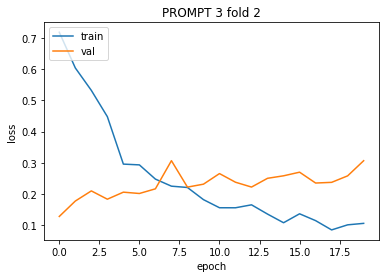

all done


In [18]:
model=[]
history=[]
for prompt in range(0,4):
  print('Preparing embedding matrix.')


  embeddings_index = {}
  with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'),encoding='utf8') as f:
      for line in f:
          values = line.split()
          word = values[0]
          coefs = np.asarray(values[1:], dtype='float32')
          embeddings_index[word] = coefs

  num_words = min(MAX_NUM_WORDS, len(word_indexes[prompt])) + 1
  embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
  for word, i in word_indexes[prompt].items():
      if i > MAX_NUM_WORDS:
          continue
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector

  embedding_layer = Embedding(num_words,
                              EMBEDDING_DIM,
                              embeddings_initializer=Constant(embedding_matrix),
                              input_length=MAX_NUM_WORDS,
                              trainable=False)
  print("Preparing of embedding matrix is done")
  rnnmodel = Sequential()
  rnnmodel.add(embedding_layer)
  rnnmodel.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
  rnnmodel.add(Dense(32, activation='relu'))
  rnnmodel.add(Dense(1, activation='relu'))
  rnnmodel.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mae'])
  print(rnnmodel.summary())
  fold=0
  for train_index, test_index in KFold(3,shuffle=True).split(sequences[prompt]):
    print('\n Prompt ',prompt,' Fold ',fold)
    x_train, x_val = sequences[prompt][train_index], sequences[prompt][test_index]
    y_train, y_val = labels[prompt][train_index], labels[prompt][test_index]
    his=rnnmodel.fit(x_train, y_train,
            batch_size=32,
            epochs=20,
            validation_data=(x_val, y_val))
    
    path = "/content/gdrive/My Drive/aes_born_"+str(prompt)+".h5" 
    rnnmodel.save(path)

    plt.plot(his.history['loss'])
    plt.plot(his.history['val_loss'])
    plt.title('PROMPT '+str(prompt)+' fold '+str(fold))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
  
    history.append(his)
    fold+=1

    # summarize history for loss

  model.append(rnnmodel)

print('all done')

## **STEP SIX: PREDICTIONS**

In [21]:


def score(text,prompt):
  prompt=prompt_to_index[prompt]
  text=cleaner(text)
  input_seq=tokenizer[prompt].texts_to_sequences([text]);
  ans=model[prompt].predict(input_seq)
  ans=ans[0][0]
  ans=round((ans*2), 0)/2
  return ans


test_df=pd.read_csv('/content/sample_data/test.csv')
test_df['predicted_score']=test_df.loc[:,["essay","promptId"]].apply(lambda x: score(x[0],x[1]),axis=1)

In [32]:
test_df.to_csv('test_prediction.csv')
test_df.head()

,Unnamed: 0,promptId,uniqueId,essay,predicted_score
0,0,1,1_315,Curriculum has been adopted in many schools. T...,3.0
1,1,1,1_214,"I strongly agree with the statement , The tig...",3.0
2,2,1,1_196,Imagination and creativity is the most importa...,4.0
3,3,1,1_178,In our eduction system leaves no room for imag...,3.5
4,4,1,1_201,"I will agree at some what extend, because if w...",2.5
